# David Seroussi - Léo Le Henaff

## Person Re-identification Project

### Path où se situe Market1501 et attributes.json

In [16]:
main_path = '/home/david/Documents/cours_cnn/projet CNN ESME 2019'

### Importation des libraries

In [2]:
import numpy as np
import pandas as pd
from os import walk 
import json
import os
import tensorflow as tf
import imgaug as ia
import imgaug.augmenters as iaa
import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

print(tf.__version__)

1.14.0


### Importation des labels depuis le fichier json

In [3]:
def get_labels(json_data):
    
    """
    Fonction permettant de mettre les labels sous forme de dataframe à partir d'un objet json.
    On réduit l'age en 2 catégories, car young et old sont très minoritaires.
    """
    
    df = pd.DataFrame(columns=json_data.keys())
    for key in json_data.keys():
        df[key] = json_data[key]

    df.set_index('image_index', inplace=True)
    df.sort_index(inplace=True)
    df.index = df.index.astype(int)

    df = df-1

    df.loc[df['age'] == 1, 'age'] = 0
    df.loc[df['age'] > 1, 'age'] = 1

    return df.sort_index(axis=1)

In [17]:
def get_train_test_labels():
    
    """
    Retourne les labels pour les sets de train/test
    """
    
    with open( main_path + '/market_attribute.json') as json_file:
        data = json.load(json_file)
        train = data['train']
        test = data['test']

    return get_labels(train), get_labels(test)

In [34]:
def get_train_test_images():
    
    """
    Retourne une liste contenant le nom des images
    """
    
    files = []
    for (dirpath, dirnames, filenames) in walk(main_path + "/Market-1501"):
        files.extend(filenames)
        break
        
    print('number of images:', len(files))
    
    files.sort()
    
        
    train_images = []
    test_images = []
    with open(main_path + '/market_attribute.json') as json_file:
        data = json.load(json_file)
        train_indexes = data['train']['image_index']
        test_indexes = data['test']['image_index']
        for i, file in enumerate(files):
            if file[:4] in train_indexes:
                train_images.append(file)
            elif file[:4] in test_indexes:
                test_images.append(file)
                
    return np.array(train_images), np.array(test_images)

### Custom Generator

In [19]:
class ImageGenerator(tf.keras.utils.Sequence):

    """
    Generator permettant de générer des batchs d'images et leur label correspondant.
    
    list_IDs: la liste du nom des images
    labels: les labels sous forme de dataframe, avec l'id de l'image en index
    model_type: 'multilabel' pour classifier uniquement les attributs ou 
                None pour classifier les attributs et les ids
    should_augment: True active l'augmentation, False la désactive
    batch_size: taille du batch
    dim: dimensions des images
    n_classes: nombre d'attributs
    n_ids: nombre d'ids,
    shuffle: True mélange, False laisse dans l'order tel quel
    """
    
    def __init__(self, list_IDs, labels, model_type=None, should_augment=False, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=10,n_ids=750, shuffle=True):

        self.model_type = model_type
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_ids = n_ids
        self.shuffle = shuffle
        self.should_augment = should_augment
        self.on_epoch_end()
        self.init_augment()

    def init_augment(self):
        
        """
        Initialisation des fonctions d'augmentation
        """
        
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            iaa.ContrastNormalization((0.75, 1.5)),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-10, 10),
                shear=(-8, 8)
            )
        ], random_order=True) # apply augmenters in random order

    def augment(self, images):
        images_aug = self.seq(images=images)
        return images_aug

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        """
        Génère les indexes des images du prochain batch
        """
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        
        """
        Génère les images et les labels
        """
        
        X = np.empty((self.batch_size, * self.dim, self.n_channels))
        y_attributes = np.empty((self.batch_size, self.n_classes), dtype=int)
        y_id = np.empty((self.batch_size, self.n_ids), dtype=int)

        for i, image_path in enumerate(list_IDs_temp):

            img = tf.keras.preprocessing.image.load_img(main_path + "/Market-1501/" + image_path, target_size=(224, 224, 3))
            
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            # Augmente les images 1 fois sur 2
            if self.should_augment and np.random.choice([0,1]) == 0:
                img_array = self.augment([img_array])[0]

            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

            img_index = int(image_path[:4])

            labels = self.labels.loc[img_index]

            X[i, ] = img_array
            y_attributes[i, ] = labels
            y_id[i, ] = tf.keras.utils.to_categorical(self.labels.index.get_loc(img_index), num_classes=self.n_ids)

        if self.model_type == 'multilabel':
            return X, y_attributes

        return X, { 'dense_8': y_attributes, 're_id': y_id }



In [20]:
def confusion_matrix(generator, labels):
    
    """
    Affiche une matrice de confusion (ne marche pas du tout à 100%)
    """
    
    pred_labels = []
    true_labels = []

    for (X, y) in generator:
        preds = model.predict(X)
    for pred, label in zip(preds, y):
        pred_labels.append(labels[np.argmax(pred)])
        true_labels.append(labels[np.argmax(label)])

    np.set_printoptions(3, suppress=True)
    conf = sklearn.metrics.confusion_matrix(true_labels, pred_labels, labels=labels)
    conf = conf / conf.astype(np.float).sum(axis=1)

    metrics = sklearn.metrics.precision_recall_fscore_support(true_labels, pred_labels, average='macro')
    print(metrics)

    skplt.metrics.plot_roc_curve(y_true, y_probas)
    plt.show()

    df_cm = pd.DataFrame(conf, index = labels, columns = labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

In [21]:
def plot_history(history):
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['acc'], 'r')
    plt.plot(history.history['val_acc'], 'b')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [22]:
def remove_unlabeled(labels, images):
    
    """
    Permet de retirer les images pour lesquelles aucune couleur n'est labellisée.
    Au final nous n'utiliserons pas cette fonction.
    """
    
    keys_to_remove = []
    for key, val in labels.items():
        if np.sum(val[13:21] - 1) == 0:
            keys_to_remove.append(key)

    for key in keys_to_remove:
        labels.pop(key, None)

    new_images = [im for im in images if im[:4] not in keys_to_remove]

    return labels, new_images

In [23]:
def load_model(path):
    model = tf.keras.models.load_model(path)
    return model

### Différents Modèles

In [29]:
def attributes_model(n_attributes=27):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    #model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu', name='features'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_attributes, activation='sigmoid', name='attributes'))

    # for layer in model.layers[0].layers:
    #     layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0003),
                loss="binary_crossentropy",
                metrics=["accuracy"])

    print(model.summary())

    return model

def id_model(n_attributes=24, n_ids=750, lambda_=0.8, cnn_model=None, freeze_cnn=False, freeze_ids=False):
    
    """
    Modèle pour la classification d'id.
    On utilise l'optimizer SGD (car Adam donne de mauvais résultats avec la double loss)
    
    n_attributes: nombre d'attributs à classifier
    n_ids: nombre d'ids à classifier
    lambda: coefficient multiplicateur de la loss (voir paper)
    cnn_model: modèle pré-entrainé sur les attributs. Si None, un modèle est créé.
    freeze_cnn: freeze la partie cnn si True
    freeze_ids: freeze la partie id si True
    """

    if cnn_model == None:

        cnn_model = tf.keras.models.Sequential()
        cnn_model.add(tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
        cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())
        cnn_model.add(tf.keras.layers.Dropout(0.5))
        cnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
        cnn_model.add(tf.keras.layers.BatchNormalization())
        cnn_model.add(tf.keras.layers.Dropout(0.5))

        image_input = tf.keras.layers.Input(shape=(224, 224, 3))
        feature_vector = cnn_model(image_input)

        attributes_layer = tf.keras.layers.Dense(n_attributes, activation='sigmoid')(feature_vector)

    else:

        image_input = cnn_model.input

        feature_vector = cnn_model.get_layer("dense_7").output
        attributes_layer = cnn_model.get_layer("dense_8").output

    re_weighting = tf.keras.layers.Dense(n_attributes, activation='sigmoid')(attributes_layer)
    re_weighted_layer = tf.keras.layers.multiply([re_weighting, attributes_layer],  name='dense_8')

    combined_features_layer = tf.keras.layers.concatenate([feature_vector, re_weighted_layer])
    re_id_layer = tf.keras.layers.Dense(n_ids, activation='softmax', name='re_id')(combined_features_layer)

    if freeze_cnn:
        for layer in cnn_model.layers:
            layer.trainable = False

    if freeze_ids:
        re_id_layer.trainable = False


    model = tf.keras.models.Model(inputs=image_input, outputs=[re_weighted_layer, re_id_layer])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                loss={
                    'dense_8':'binary_crossentropy', 
                    're_id':'categorical_crossentropy'
                },
                loss_weights={
                    'dense_8': (1-lambda_),
                    're_id': lambda_
                },
                metrics=['accuracy'])

    print(model.summary())

    return model



def multitask_model():
    
    """
    Modèle séparant couleurs et autres attributs avec 2 loss différentes (categorical et binary).
    """
    
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())
    cnn_model.add(tf.keras.layers.Dropout(0.5))
    cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(0.5))

    # for layer in cnn_model.layers[0].layers:
    #   layer.trainable = False

    image_input = tf.keras.layers.Input(shape=(224, 224, 3))
    feature_vector = cnn_model(image_input)

    gender_layer = tf.keras.layers.Dense(256, activation='relu')(feature_vector)
    gender_layer = tf.keras.layers.BatchNormalization()(gender_layer)
    gender_layer = tf.keras.layers.Dropout(0.5)(gender_layer)
    gender_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(gender_layer)

    upcolor_layer = tf.keras.layers.Dense(256, activation='relu')(feature_vector)
    upcolor_layer = tf.keras.layers.BatchNormalization()(upcolor_layer)
    upcolor_layer = tf.keras.layers.Dropout(0.5)(upcolor_layer)
    upcolor_layer = tf.keras.layers.Dense(8, activation='softmax', name='upcolor')(gender_layer)

    model = tf.keras.models.Model(inputs=image_input, outputs=[gender_layer, upcolor_layer])
    model.compile(optimizer='adam',
            loss={'gender':'binary_crossentropy', 
                  'upcolor':'categorical_crossentropy'},
            metrics=['accuracy'])

    print(model.summary())

  
    return model

### Création des générateurs

In [31]:
attributes_length = 30
batch_size = 32

train_images, test_images = get_train_test_images()
train_labels, test_labels = get_train_test_labels()

# attributes
ig_train_attributes = ImageGenerator(train_images, train_labels, n_classes=27, n_ids=len(train_labels) ,should_augment=True)
ig_test_attributes = ImageGenerator(test_images, test_labels, n_classes=27, n_ids=len(test_labels))


# re-id

# On enlève ces trois attributs qui ont obtenus une ROC très faible lors de la classification d'attributs
labels_to_remove = ['handbag', 'up', 'hat']
train_labels = train_labels.drop(labels_to_remove, axis=1)
test_labels = test_labels.drop(labels_to_remove, axis=1)

# On sépare en train/test tout le dataset. 
# On va donc essayer de prédire sur les 1501 ids
all_images = np.concatenate((train_images, test_images))
all_labels = train_labels.append(test_labels)
np.random.shuffle(all_images)
train_index = int(0.75 * len(all_images))

ig_train_reid = ImageGenerator(all_images[:train_index], all_labels, n_classes=24, n_ids=len(all_labels), should_augment=True)
ig_test_reid = ImageGenerator(all_images[train_index:], all_labels, n_classes=24, n_ids=len(all_labels))

number of images: 25260


### Création des modèles

In [30]:
model_attributes = attributes_model(n_attributes=ig_train_multilabel.n_classes)

model_re_id = id_model(n_attributes=ig_train_reid.n_classes, n_ids=ig_test_reid.n_ids)

/home/david/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0202 23:33:09.415047 140447036118848 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0202 23:33:09.638098 140447036118848 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which h

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
features (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
attributes (Dense)           (None, 27)                1

/home/david/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          24638848    input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 24)           12312       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 24)           600         dense_1[0][0]                    
______________________________________________________________________________________________

### Entraînement des modèles

In [33]:
%%time

def lr_decay(epoch, current_lr):
    if epoch > 40:
        return current_lr / 10.0
    return current_lr 

checkpoint = tf.keras.callbacks.ModelCheckpoint("./projet-cnn/cnn_re_id.h5",monitor="val_re_id_acc", save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_re_id_acc", patience=5)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger('./training_cnn_re_id.log')

epochs=60

# Pour train le modèle attributes only, il suffit de remplacer 
# model_re_id par model_attributes
# ig_train_reid par ig_train_attributes et ig_test_reid par ig_test_attributes

history = model_re_id.fit_generator(
    ig_train_reid,
    validation_data=ig_test_reid,
    epochs=epochs,
    callbacks=[earlyStopping, checkpoint, reduce_lr, csv_logger]
)

# history = model_attributes.fit_generator(
#     ig_train_attributes,
#     validation_data=ig_test_attributes,
#     epochs=epochs,
#     callbacks=[earlyStopping, checkpoint, reduce_lr, csv_logger]
# )

0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/60
  1/592 [..............................] - ETA: 14:57:41 - loss: 6.3018 - dense_8_loss: 0.6148 - re_id_loss: 7.7235 - dense_8_acc: 0.7174 - re_id_acc: 0.0000e+00

KeyboardInterrupt: 

### Distance Euclidienne

In [ ]:
model = load_model('./cnn_re_id.h5')

In [0]:
print('train:',model.evaluate_generator(ig_train_reid))
print('test:',model.evaluate_generator(ig_test_reid))
#print('train without augment', model.evaluate_generator(ImageGenerator(train_images, train_labels, "upcolor", should_augment=False, n_classes=8)))

train: [0.7780446510533897, 0.1577774, 0.6202673, 0.9365899, 0.81584823]


In [0]:
# On récupère la couche de 512 neurones après le ResNet pour obtenir le feature vector

model_intermediate = tf.keras.models.Model(inputs=model.layers[1].input, outputs=[model.layers[1].get_layer('dense').output])
model_intermediate.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
Total params: 24,636,800
Trainable params: 24,583,680
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
"""
Compare le feature vector d'une image (query) avec toutes les autres images du dataset.
Classe les images par ordre croissant (plus petite distance d'abord)
"""

image_to_test = '0780_c1s4_066836_00.jpg'

img = tf.keras.preprocessing.image.load_img( "projet CNN ESME 2019/Market-1501/" + image_to_test, target_size=(224, 224, 3))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

ig_euclidean = ImageGenerator(all_images[all_images != image_to_test], all_labels, should_augment=False, batch_size=256, n_classes=24, n_ids=1501, shuffle=False)

dists = dict()

img_to_test = model_intermediate.predict(np.expand_dims(img_array, axis=0))

for X,y in ig_euclidean:
    for pred, id_ in zip(model_intermediate.predict(X), y['re_id']):
        dist = np.linalg.norm(img_to_test - pred)
        dists[np.argmax(id_)] = np.min(np.append(dists.get(np.argmax(id_), []), dist))

dists = {k: v for k, v in sorted(dists.items(), key=lambda item: item[1])}

KeyboardInterrupt: ignored

### Analyse de la prédiction d'attributs (sans les couleurs)

In [8]:
df_preds = pd.DataFrame(columns=['age', 'backpack', 'bag', 'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender'])
df_labels = pd.DataFrame(columns=['age', 'backpack', 'bag', 'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender'])

for (X,y) in ig_test_multilabel:
    preds = model.predict(X)
    df_preds = df_preds.append(pd.DataFrame(np.round(preds), columns=['age', 'backpack', 'bag', 'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender']))
    df_labels = df_labels.append(pd.DataFrame(y, columns=['age', 'backpack', 'bag', 'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender']))

NameError: name 'ig_test_multilabel' is not defined

In [0]:
columns = ['age', 'backpack', 'bag', 'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender']

from sklearn.metrics import roc_auc_score

for column in columns:
    score = round(roc_auc_score(df_labels[column], df_preds[column])*100, 2)
    print(column, score)

age 66.15
backpack 76.74
bag 62.47
handbag 50.35
clothes 83.92
down 92.65
up 50.0
hair 85.13
hat 50.0
gender 88.29


In [0]:
conf_matrix = sklearn.metrics.confusion_matrix(df_labels['age'], df_preds['age'])
fp = round(conf_matrix[1][0]/(conf_matrix[1][0]+conf_matrix[1][1])*100, 2)
fn = round(conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])*100, 2)

print('faux pos:', fp)
print('faux neg:', fn)

print('vrai pos:', 100 - fp)
print('vrai neg:', 100 - fn)


faux pos: 61.82
faux neg: 5.88
vrai pos: 38.18
vrai neg: 94.12


(0.794247853472613, 0.8046640825522557, 0.7934903073181514, None)


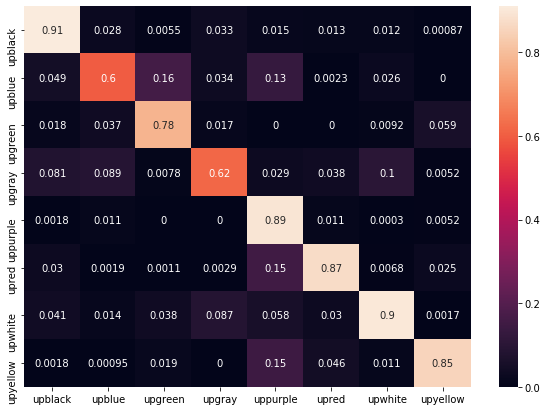

In [0]:
upcolor_labels = ['upblack', 'upblue', 'upgreen', 'upgray', 'uppurple', 'upred', 'upwhite', 'upyellow']
gender_labels = ['man', 'woman']
confusion_matrix(ig_test_upcolor, upcolor_labels)